In [1]:
import os
import cv2
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from model import YoloV1
from dataset import inference_tfms
from metrics import out2boxlist, non_max_suppression
from utils import plot_img_with_bboxes

device = 'cuda' if torch.cuda.is_available() else 'cpu'
cmap = plt.cm.hsv(np.linspace(0, 1, 20))

# Results

In [2]:
results = pd.read_csv('./logs/2023_07_06/0/results_partial_fold_0_of_10_iou_05.txt')

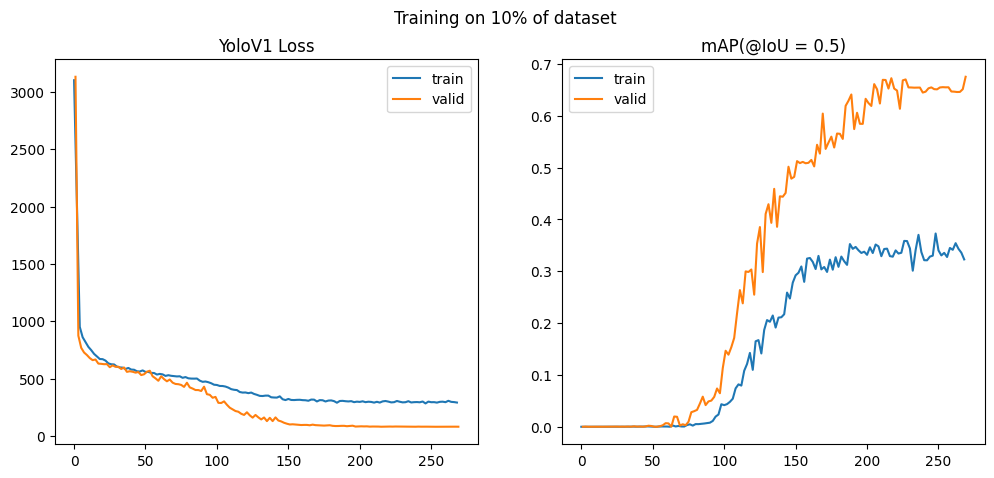

In [3]:
train_results = results.query("phase=='train'")
valid_results = results.query("phase=='valid'")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].plot(train_results['loss'], label='train')
axes[0].plot(valid_results['loss'], label='valid')
axes[0].set_title('YoloV1 Loss')
axes[0].legend()
axes[1].plot(train_results['mAP'], label='train')
axes[1].plot(valid_results['mAP'], label='valid')
axes[1].set_title('mAP(@IoU = 0.5)')
axes[1].legend()
plt.suptitle("Training on 10% of dataset")
plt.show()

# Test

In [4]:
model = YoloV1()
model.load_state_dict(torch.load('./logs/2023_07_06/0/model_partial_fold_0_of_10_iou_0.5.pth',
                                 map_location=device))

<All keys matched successfully>

In [5]:
image_paths = '../VOCdevkit/VOC2012/JPEGImages/'
image_path = image_paths + os.listdir(image_paths)[10]

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
height, width = image.shape[0], image.shape[1]

image_tfmed = inference_tfms()(image=image)['image'].unsqueeze(0)

In [6]:
model.eval()
with torch.inference_mode():
    out = model(image_tfmed)
    pred_bboxes = out2boxlist(out)
    nms_bboxes = non_max_suppression(pred_bboxes[0])

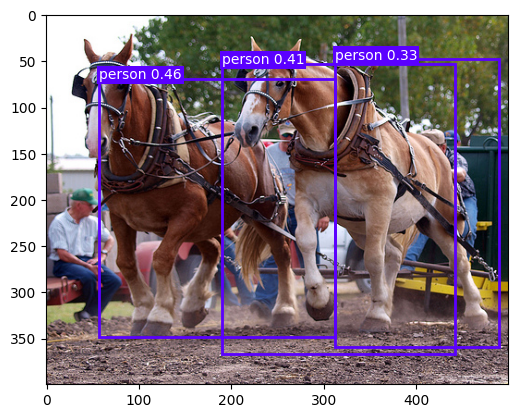

In [7]:
plot_img_with_bboxes(image, nms_bboxes)